In [ ]:
# installing tensorflow_text
!pip install tensorflow-text

In [ ]:
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# load data
df = pd.read_csv('ham-spam-phishing.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I dont think he goes to usf, he lives arou..."
4,ham,Even my brother is not like to speak with me. ...
...,...,...
5756,phishing,2 new message
5757,phishing,your bill is here
5758,phishing,please check your
5759,phishing,"email has been reposted , regulation"


In [ ]:
# check count and unique and top values and their frequency
df['Category'].value_counts()

ham         4825
spam         747
phishing     189
Name: Category, dtype: int64

Clearly dataset is imbalanced - not so much but still it can affect our model. Need to use some type of regulariztion like downsampling dataset for mazority class

In [ ]:
# check percentange of data - states how much data needs to be balanced
str(round(747/4825,2))+'%'

'0.15%'

In [ ]:
# creating 2 new dataframe as df_ham , df_phishing

df_ham = df[df['Category']=='ham']
print("Ham Dataset Shape:", df_ham.shape)

df_spam = df[df['Category']=='spam']
print("Spam Dataset Shape:", df_spam.shape)

Ham Dataset Shape: (4825, 2)
Spam Dataset Shape: (747, 2)


In [ ]:
# downsampling ham dataset - take only random 189 example
# will use df_spam.shape[0] - 199

df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
# concating both dataset - df_spam and df_ham_balanced to create df_balanced dataset
df_balanced = pd.concat([df_spam , df_ham_downsampled])
df_balanced.head()

,Category,Message
4825,spam,Free entry in 2 a wkly comp to win FA Cup fina...
4826,spam,FreeMsg Hey there darling its been 3 weeks now...
4827,spam,WINNER As a valued network customer you have b...
4828,spam,Had your mobile 11 months or more? U R entitle...
4829,spam,"SIX chances to win CASH From 100 to 20,000 pou..."


In [ ]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [ ]:
df_balanced.sample(10)

,Category,Message
4938,spam,You have an important customer service announc...
5096,spam,Free 1st week entry 2 TEXTPOD 4 a chance 2 win...
1276,ham,Cant believe i said so many things to you this...
4827,spam,WINNER As a valued network customer you have b...
5563,spam,"SMS SERVICES. for your inclusive text credits,..."
2644,ham,What u talking bout early morning? Its almost ...
673,ham,Gud mrng dear hav a nice day
5394,spam,"cmon babe, make me horny, *turn* me on Txt me ..."
5232,spam,No 1 POLYPHONIC tone 4 ur mob every week Just ...
2502,ham,Come aftr &lt;DECIMAL&gt; ..now i m cleaning ...


Data Prepration


In [ ]:
# creating numerical repersentation of category - one hot encoding
df_balanced['spam'] = df_balanced['Category'].apply(lambda x:1 if x=='spam' else 0)

In [ ]:
# displaying data - phishing -1 , spam-0
df_balanced.sample(4)

,Category,Message,spam
1214,ham,Lmao. Take a pic and send it to me.,0
1037,ham,Teach me apps da. When you come to college.,0
3438,ham,Love you aathi..love u lot..,0
5186,spam,Hello darling how are you today? I would love ...,1


Do train-test split
split dataset into 80-20 ratio with 80% train and remaing as test
for eveness of data we will use stratify agrument which ensures same ratio of both category is loaded for each case, even if one categoy has more training samples - prevents overfitting

In [ ]:
# loading train test split
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Message '], df_balanced['spam'],
                                                    stratify = df_balanced['spam'])

In [ ]:
# check for startification
y_train.value_counts()

0    560
1    560
Name: spam, dtype: int64

In [ ]:
560/560

1.0

In [ ]:
y_test.value_counts()

1    187
0    187
Name: spam, dtype: int64

In [ ]:
187/187

1.0

In [ ]:
# downloading preprocessing files and model
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
import tensorflow as tf

In [ ]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

# creating final model
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [ ]:
# check summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

Compiling model
Optimizer - ADAM
Loss - binary_crossentropy
metrics - accuracy , precesion and recall

In [ ]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [ ]:
import tensorflow as tf
import datetime
%load_ext tensorboard

!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(X_train, y_train, epochs = 2 , callbacks = [tensorboard_callback])

Epoch 1/2
35/35 [==============================] - 587s 16s/step - loss: 0.6260 - accuracy: 0.6598 - precision: 0.6607 - recall: 0.6571
Epoch 2/2
35/35 [==============================] - 576s 16s/step - loss: 0.5025 - accuracy: 0.8125 - precision: 0.8193 - recall: 0.8018


In [ ]:
# Evaluating performace
model.evaluate(X_test,y_test)

12/12 [==============================] - 184s 15s/step - loss: 0.4565 - accuracy: 0.8610 - precision: 0.8358 - recall: 0.8984


[0.4565407931804657,
 0.8609625697135925,
 0.8358209133148193,
 0.8983957171440125]

In [ ]:
# getting y_pred by predicting over X_text and flattening it
y_pred = model.predict(X_test)
y_pred = y_pred.flatten() # require to be in one dimensional array , for easy maniputation


12/12 [==============================] - 172s 14s/step


In [ ]:
# checking the results y_pred
import numpy as np

y_pred = np.where(y_pred>0.5,1,0 )
y_pred

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,

In [ ]:
# importing consfusion maxtrix
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
# creating confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[154,  33],
       [ 19, 168]])

In [ ]:
# plotting as graph - importing seaborn
import seaborn as sns

Text(50.722222222222214, 0.5, 'Actual')

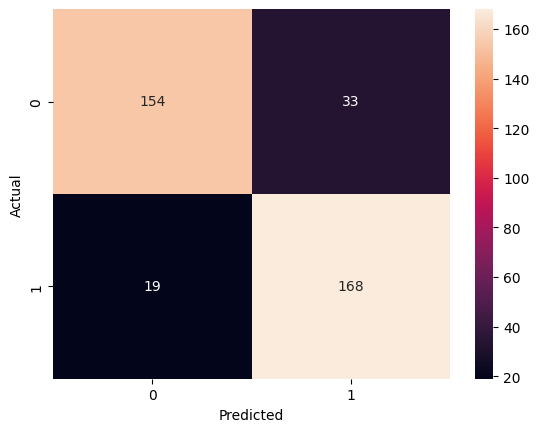

In [ ]:
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# printing classification report
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86       187
           1       0.84      0.90      0.87       187

    accuracy                           0.86       374
   macro avg       0.86      0.86      0.86       374
weighted avg       0.86      0.86      0.86       374



Good Precision And Recall Score, but can be improved

Model Prediction
We will be predicting data on text coprus, value > 5 is most likely be Spam


In [ ]:
predict_text = [
                #Ham
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund',
                'Your account is temporarily frozen. Please log in to to secure your account ',

                #spam
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
]

In [ ]:
test_results = model.predict(predict_text)

1/1 [==============================] - 4s 4s/step


In [ ]:
output = np.where(test_results>0.5,'spam', 'ham')

In [ ]:
output

array([['spam'],
       ['spam'],
       ['spam'],
       ['ham'],
       ['spam'],
       ['spam']], dtype='<U4')

Create a function which will take in sentece array and return the embedding vector for entire sentece -pooled_output

In [ ]:
def get_embedding(sentence_arr):
    'takes in sentence array and return embedding vector'
    preprocessed_text = bert_preprocessor(sentence_arr)
    embeddings = bert_encoder(preprocessed_text)['pooled_output']
    return embeddings

In [ ]:
e = get_embedding([
               'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
               'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
])

In [ ]:
# load similartiy score
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# check similarity score
print(f'Similarity score between 1st sentence(spam) and second sentence(spam) : {cosine_similarity([e[0]] , [e[1]])}')

Similarity score between 1st sentence(spam) and second sentence(spam) : [[0.85391915]]
